# Generate Mac270 river temperature forcing from llc270 files

In [3]:
import os
import time
import numpy as np
import pandas as pd
from struct import *
from MITgcmutils import mds
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import personal python tool
import sys
sys.path.append("./../../rtools")
from llc2mac import llc2mac

## I. Read data

### a. Set path to data

In [6]:
# Set parameters
HDlist = os.listdir('/Volumes') 
HDsel = np.nan
HD = ["Proteus","Itsasorantz"]
# HD Selection
while not (HDsel==1 or HDsel==2):
    # While loop Intilization
    if not np.isnan(HDsel):
        print("Wrong choice ! Type 1 or 2")
    # Test Both HD pluged in case    
    if HD[0] in HDlist and HD[1] in HDlist:
        HDsel = int(input("Do you want to read data on (1) Proteus or (2) Itsasorantz ?"))
    # Selection for 1 HD pluged in
    elif HD[0] in HDlist:
        HDsel = 1
    elif HD[1] in HDlist:
        HDsel = 2
print(f"Reading data on {HD[HDsel-1]}")

Reading data on Itsasorantz


In [14]:
HDpath = f"/Volumes/{HD[HDsel-1]}/"
Data_pth = HDpath+'Modelling/Forcing/River_runoff/mac270/Temperature/'
Grd_pth = HDpath+'Modelling/Forcing/grids/mac270/G46x68x46/'
MacIn_pth = HDpath+'Data/ECCO-darwin/delta_inlets/mac270/'

### b. Read raw Tokuda temperature fields

In [11]:
# Get file name
fname = np.sort(os.listdir(Data_pth+'Tokuda_llc270/'))[1:]
# Set time line
Date = pd.date_range(fname[0][-4:]+'-01-01',fname[-1][-4:]+'-12-31',freq='d')

In [12]:
itr = 0
Tmac270 = []
with ProgressBar(max_value=len(fname)) as bar:
    for fnm in fname:
        # Read data
        nt = len(Date[Date.year==int(fnm[-4:])])
        Tmac270.append(llc2mac(Data_pth+'Tokuda_llc270/'+fnm, nt, "46x68"))
        # Update bar
        time.sleep(0.1); itr+=1; bar.update(itr)

100% (30 of 30) |########################| Elapsed Time: 0:05:05 Time:  0:05:05


### c. Read mac270 grid parameter

In [16]:
# read mac270 grid
XC = mds.rdmds(Grd_pth+'XC')
YC = mds.rdmds(Grd_pth+'YC')
MaskC = mds.rdmds(Grd_pth+'maskInC')
# read mac270 inlets
inlet = np.load(MacIn_pth+'Inlets_v2.npy')

## II. Plot inlet situation

In [17]:
# Setup Mackenzie shelf Situation (Lambert Conformal basemap)
m = Basemap(width=400000,height=360000,projection='lcc',
            resolution='i',lat_1=69.,lat_2=71,lat_0=69.5,lon_0=-135.)
#Coordinates
parallels = np.arange(68.,72,1.)
meridians = np.arange(-141.,-120.,3.)

In [18]:
# Set elements for plot
col = ['tab:orange','tab:blue','tab:green']
Coor = np.array([np.meshgrid([-136.2,-135.4],[68.75,69.05]),np.meshgrid([-135.6,-135],[69.35,69.55]),
                 np.meshgrid([-134.1,-133.4],[69.25,69.5])])

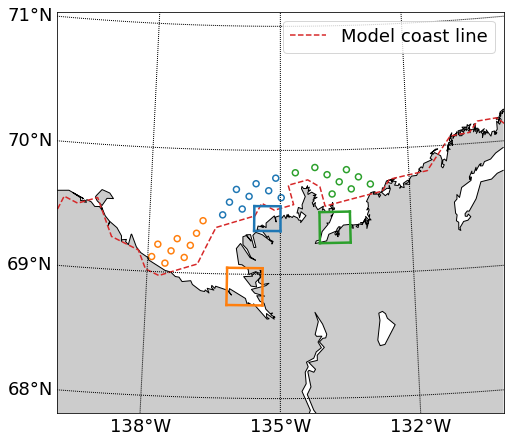

In [19]:
fig = plt.figure(figsize=(8,8))

###  Basemap coast   ###
m.drawcoastlines()
m.fillcontinents(color="#cccccc")
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=18) # (labels = [left,right,top,bottom])
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=18) # (labels = [left,right,top,bottom])
###   Plot Model Coastline   ###
m.contour(XC, YC, MaskC, levels=[0], linestyles="--", colors='tab:red', latlon=True)
plt.legend(fontsize=18, handles=[Line2D([0], [0], color='tab:red',lw=1.5, 
                                        linestyle='--', label='Model coast line')], loc=1)

### Plot inlets ###
for i in range(3):
    ### Inlet Boxes
    m.plot(Coor[i][0],Coor[i][1], col[i], linewidth=2.5, latlon=True)
    m.plot(Coor[i][0].T,Coor[i][1].T, col[i], linewidth=2.5, latlon=True)
    ### Entry point
    id_temp = np.where(inlet==i+1)
    for j in range(len(id_temp[0])):
        m.scatter(XC[id_temp[0][j],id_temp[1][j]], YC[id_temp[0][j],id_temp[1][j]], latlon=True,
                 marker='o', facecolors='none', edgecolors=col[i], linewidths=1.5)

plt.show()

## III. Processing the mac270 T° modified forcing

In [20]:
# Create matrix of 1 on inlet point
inlet1 = inlet.copy()
inlet1[inlet1>0] = 1
# Create the T° forcing matrix
Tmac270_modif = []
for i in range(len(Tmac270)):
    Tmac270_modif.append(Tmac270[i]*inlet1)

###### Verification plot

In [21]:
Tmac4plot = Tmac270_modif[0].copy()
for i in range(1,len(Tmac270_modif)):
    Tmac4plot = np.concatenate([Tmac4plot,Tmac270_modif[i]])

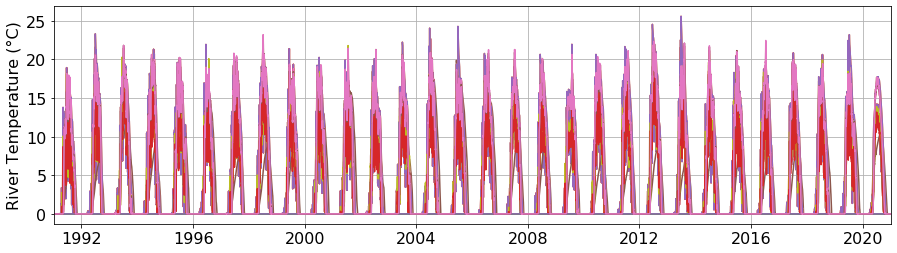

In [22]:
plt.figure(figsize=(15,4))
for i in range(len(np.where(inlet>0)[0])):
    plt.plot(Date,Tmac4plot[:,np.where(inlet>0)[0][i],np.where(inlet>0)[1][i]])
plt.grid(True)
plt.xlim([Date[0],Date[-1]])
plt.ylabel('River Temperature (°C)', fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

## IV. Save Forcing matrixes

In [37]:
def bin_save(fnm, array):
    newFile = open(fnm, "wb")
    bitearray = pack(">%sf" % len(array.flatten()),*array.flatten())
    newFile.write(bitearray);

### a. Save the raw matrix zoomed on Mac270

In [16]:
# Set directory
if not 'Tokuda_Mac270' in os.listdir(Data_pth):
    os.mkdir(Data_pth+"Tokuda_Mac270/")
# Save forcing files   
yr_ls = list(set(Date.year))
for i in range(len(Tmac270)):
    bin_save(Data_pth+"Tokuda_Mac270/wattmp_mac270_"+str(yr_ls[i]),Tmac270[i])

### b. save the modified matrix zoomed on Mac270

In [39]:
# Set directory
if not 'Tokuda_Mac270modif_HDist' in os.listdir(Data_pth):
    os.mkdir(Data_pth+"Tokuda_Mac270modif_HDist/")
# Save forcing files
yr_ls = list(set(Date.year))
for i in range(len(Tmac270_modif)):
    bin_save(Data_pth+"Tokuda_Mac270modif_HDist/wattmp_mac270modif_"+str(yr_ls[i]),Tmac270_modif[i])